In [152]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
import time, sys, random, operator
from time import sleep
import itertools
from matplotlib.colors import Normalize

In [2]:
%matplotlib inline

In [150]:
class Dot:
    
    def __init__(self, index, speed, ang, temp):
        self.index = index
        self.pos = [0, 0]
        self.speed = speed        
        self.ang = ang        
        self.temp = temp if temp > 0 else 0.1
    
    def get_info(self):
        return {
            "pos": self.pos,
            "speed": self.speed,
            "ang": self.ang,
            "temp": self.temp
        }
    
    def get_pos(self):
        return self.pos
    
    def get_index(self):
        return self.index
    
    def get_temp(self):
        return self.temp
    
    def set_pos(self, pos):
        self.pos = pos
        return True
    
    def set_temp(self, temp):
        self.temp = temp
        return True
    
    def get_mass(self, atm, opt):
        if(opt == "constant"):
            d = 1.225 
        else:    
            d = 0
            p = atm * 101325
            R = 287
            t = self.temp

            d = p/(R*t)
        
        return d
        
    
    def __eq__(self, other):
        return self.get_index() == other.get_index()

    def __lt__(self, other):
        return self.get_index() < other.get_index()

In [178]:
class App:
    
    def __init__(self, dimensions, dots, atm=1, mass="variable"):
        self.atm = atm
        self.dimensions = dimensions
        self.dots = dots
        self.dots_pos = {}
        self.dots_conections = []
        self.max_temp = 0
        if mass != "variable" and mass != "constant":
            self.mass = "variable"
        else:
            self.mass=mass
        self.build_plot(self.dimensions, self.dots)
        
    def build_plot(self, dimensions, dots):
        total_dots = dimensions[0] * dimensions[1]
        data = []

        if len(dots) != total_dots:
            print("Dimensões inválidas")
        else:
            x = 0
            y = 0
            d = []
            for dot in dots:
                x += 1
                info = dot.get_info()
                # set dot position
                dot.set_pos([x, y+1])
                d.append(info["temp"] - 273)
                if info["temp"] - 273 > self.max_temp:
                    self.max_temp = info["temp"] - 273
                if x == dimensions[0] :
                    data.append(d)
                    d = []
                    x = 0
                    y += 1
                    
            # load dot position
            self._load_dots_pos()

            fig, ax = plt.subplots()
            ax.imshow(data, cmap='coolwarm', norm=Normalize(0, 800))

            # draw gridlines
            ax.grid(which='major', axis='both', linestyle='-', linewidth=2)
            ax.set_xticks(np.arange(-0.5, dimensions[0], 1));
            ax.set_yticks(np.arange(-0.5, dimensions[1], 1));
            ax.set_xticklabels([])
            ax.set_yticklabels([])

            # print temperature
            for dot in dots:
                info = dot.get_info()
                pos = info['pos']
                label = info['temp']
                ax.text(pos[0]-1, pos[1]-1, label, color='black', ha='center', va='center', weight="bold")

            plt.show()
            
    def load_plot(self):
        dimensions = self.dimensions
        dots = self.dots
        data = []

        x = 0
        d = []
        for dot in dots:
            x += 1
            info = dot.get_info()
            # set dot position
            d.append(info["temp"] - 273)
            if x == dimensions[0] :
                data.append(d)
                d = []
                x = 0

        fig, ax = plt.subplots()
        ax.imshow(data, cmap='coolwarm', norm=Normalize(0, 2000))

        # draw gridlines
        ax.grid(which='major', axis='both', linestyle='-', linewidth=2)
        ax.set_xticks(np.arange(-0.5, dimensions[0], 1));
        ax.set_yticks(np.arange(-0.5, dimensions[1], 1));
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        # print temperature
        for dot in dots:
            info = dot.get_info()
            pos = info['pos']
            label = info['temp']
            ax.text(pos[0]-1, pos[1]-1, label, color='black', ha='center', va='center', weight="bold")

        plt.show()
            
    def _load_interacoes(self, dots):
        conectados = []
        for dot in dots:
            pos = dot.get_pos()
            index = dot.get_index()
            
            value = self.get_dot_per_pos([pos[0]-1, pos[1]])
            if(value):
                if index > value.get_index():
                    conectados.append([value, dot])
                else:
                    conectados.append([dot, value])  
        
            value = self.get_dot_per_pos([pos[0]+1, pos[1]])
            if(value):
                if index > value.get_index():
                    conectados.append([value, dot])
                else:
                    conectados.append([dot, value])  
            
            value = self.get_dot_per_pos([pos[0], pos[1]-1])
            if(value):
                if index > value.get_index():
                    conectados.append([value, dot])
                else:
                    conectados.append([dot, value]) 
                    
            value = self.get_dot_per_pos([pos[0], pos[1]+1])
            if(value):
                if index > value.get_index():
                    conectados.append([value, dot])
                else:
                    conectados.append([dot, value])  
        
        conectados.sort()
        self.dots_conections = list(k for k,_ in itertools.groupby(conectados))
        
        
    def _load_dots_pos(self):
        resp = {}
        for dot in dots:
            pos = dot.get_pos()
            
            resp[self._pos_to_str(pos)] = dot

        self.dots_pos = resp
        self._load_interacoes(dots)
    
    def _pos_to_str(self, pos):
        return f"{pos[0]}-{pos[1]}"
    
    def get_dot_per_pos(self, pos):
        pos = self._pos_to_str(pos)
        if pos in self.dots_pos:
            return self.dots_pos[pos]
        else:
            return False
        
    def cycle(self):
        done = False
        int_done = 0
        
        for conn in self.dots_conections:
            if conn[0].get_temp() != conn[1].get_temp():
                resp = self.calc(conn[0], conn[1])
                conn[0].set_temp(resp)
                conn[1].set_temp(resp)
            else:
                int_done += 1
                if int_done == len(self.dots_conections):
                    done = True
        
        return done
        
    def calc(self, dot1, dot2):
        # mcT + mcT = 0
        # m1.c.(Tf - Ti) + m1.c.(Tf - Ti) = 0
        # Tf = (m1 * T1 + m2 * T2) / m1 + m2
        m1 = dot1.get_mass(self.atm, self.mass)
        m2 = dot2.get_mass(self.atm, self.mass)
        T1 = dot1.get_temp()
        T2 = dot2.get_temp()
        Tf = (m1 * T1 + m2 * T2) / (m1 + m2)
        Tf = round(Tf,2)
        return Tf
        
    def run(self):
        running = True
        while running:
            self.load_plot()
            if self.cycle():
                running = False
            else:
                # set load speed
                # comment to disable
                sleep(1)
                pass
            

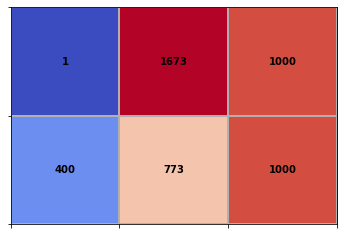

In [179]:
# set dots and dimension
dots = []
dots.append(Dot(1, 0, 0, 1))
dots.append(Dot(2, 0, 0, 1673))
dots.append(Dot(2, 0, 0, 1000))
dots.append(Dot(1, 0, 0, 400))
dots.append(Dot(2, 0, 0, 773))
dots.append(Dot(2, 0, 0, 1000))

dimensions = [3, 2]

# start App
app = App(dimensions, dots, atm=1, mass="constant")

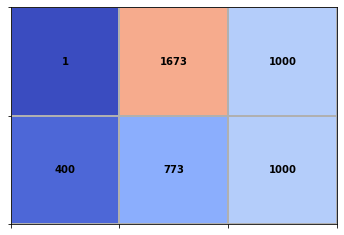

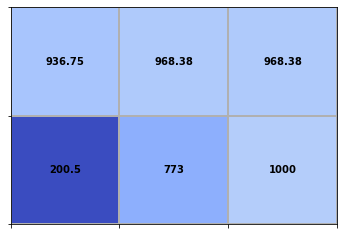

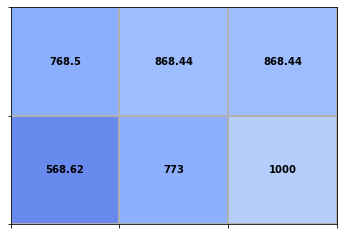

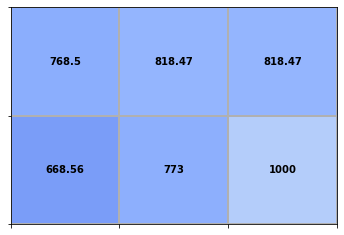

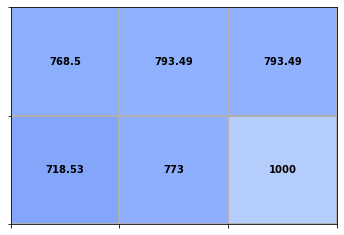

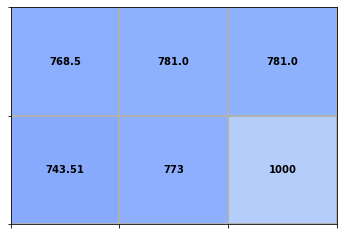

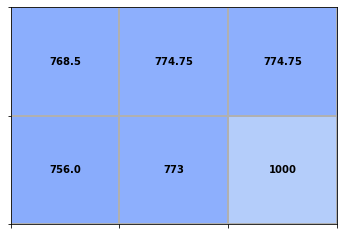

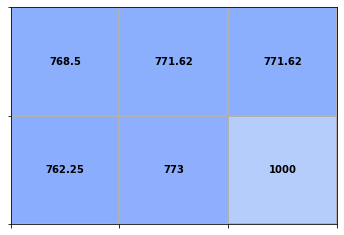

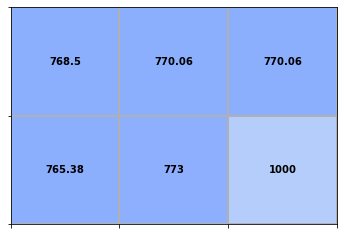

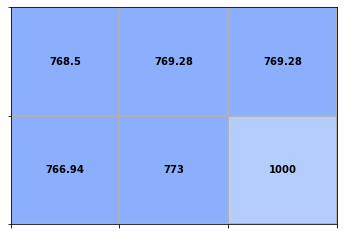

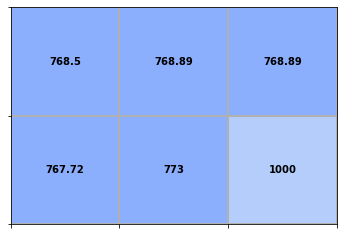

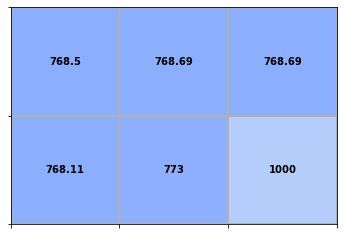

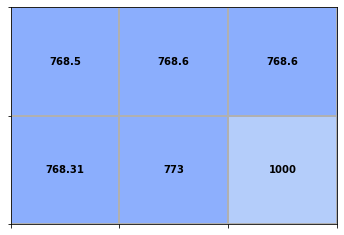

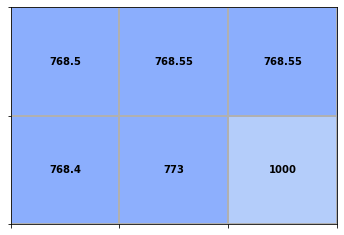

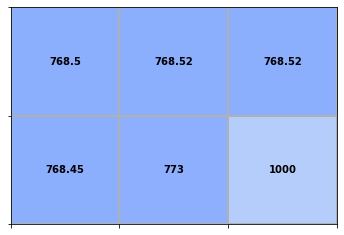

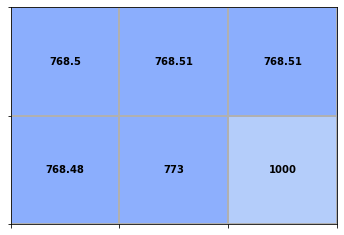

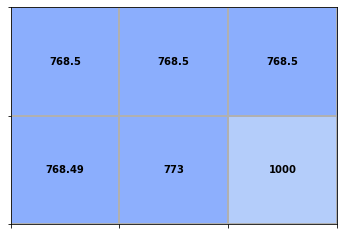

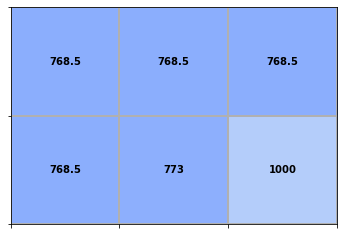

In [177]:
# run app
app.run()

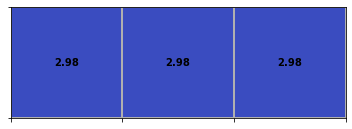

In [172]:
app.load_plot()

In [102]:
app.dots[0].get_mass(1)

TypeError: get_mass() missing 1 required positional argument: 'opt'

In [87]:
353 / (0.2245+0.9465)

301.4517506404782